In [1]:
import numpy as np
import pandas as pd
import math
from math import pi
from datetime import time, datetime
from os import path
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.power import TTestIndPower
from matplotlib import pyplot as plt
import seaborn as sns

In [24]:
%matplotlib inline
sns.set()
red = (255/255,103/255,103/255)
blue = (52/255,128/255,255/255)

# Performance Outcomes in NFL Quarterbacks Following Shoulder Surgery

### Load Data

First we load our list of QBs, that we have downloaded and selected in the other notebook:

In [25]:
# case_qbs = pd.read_csv('qb-data/case_qbs.csv')
# using date of injury instead of surgery per Alberta suggestion
case_qbs = pd.read_csv('qb-data/case_qbs_injuryAge.csv')
ctrl_qbs = pd.read_csv('qb-data/ctrl_qbs.csv')
inj_qbs = pd.read_csv('qb-data/injured_qbs.csv')
select_ctrls = {'Alex Smith': 'Michael Vick',
 'Andrew Luck': 'Joe Flacco',
 'Cam Newton': 'Robert Griffin III',
 'Chad Pennington': 'Tony Romo',
 'Don Majkowski': 'Erik Kramer',
 'Drew Brees': 'Peyton Manning',
 'Jay Cutler': 'Matt Schaub',
 'Jim McMahon': 'Jim Everett',
 'Jimmy Clausen': 'Kellen Clemens',
 'Kelly Holcomb': 'Donald Hollas',
 'Mark Sanchez': 'Kyle Orton',
 'Matt Moore': 'Geno Smith',
 'Matthew Stafford': 'Drew Bledsoe',
 'Rich Gannon': 'Tommy Kramer',
 'Ryan Leaf': 'Tim Couch',
 'Steve McNair': 'Donovan McNabb',
 'Tom Brady': 'Brett Favre',
 'Troy Aikman': 'John Elway',
 'Gary Danielson': 'Jim Kelly'}
inj_ctrls = {'Marc Bulger': 'Shaun Hill', 
 'Derek Anderson': 'Matt Cassel', 
 'Kyle Boller': 'Blaine Gabbert', 
 'Bruce Gradkowski': 'Brady Quinn', 
 'Jameis Winston': 'Josh Freeman',
 'Ben Roethlisberger': 'Aaron Rodgers',
 'Jim Miller': 'Hugh Millen', 
 'Scott Mitchell': 'Doug Johnson',
 'Gary Hogeboom': 'Steve Grogan', 
 'David Archer': 'Todd Blackledge', 
 'Tony Eason': 'Jeff Hostetler'}

Methods to access our CSV files of performance statistics:

In [26]:
def underscore(name):
    sep = name.find(' ')
    return name[:sep]+'_'+name[sep+1:]

def get_qb_stats(name, attempts=1, average=False):
    filesuff = '{}.csv'.format(underscore(name))
    if path.exists('qb-data/case/'+filesuff):
        df = pd.read_csv('qb-data/case/'+filesuff)
    elif path.exists('qb-data/control/'+filesuff):
        df = pd.read_csv('qb-data/control/'+filesuff)
    else:
        return 
    df = df[df['Att']>attempts]
    df.reset_index(drop=True, inplace=True)
    if average:
        return df.mean()
    return df

In [27]:
get_qb_stats('Tom Brady', average=False).tail()

,Year,Date,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
295,2020,2020-11-23,43.112,26.0,48.0,54.17,216.0,2.0,2.0,62.5,1.0,7.0,4.50,3.46
296,2020,2020-11-29,43.118,27.0,41.0,65.85,345.0,3.0,2.0,96.1,1.0,3.0,8.41,7.68
297,2020,2020-12-13,43.132,15.0,23.0,65.22,196.0,2.0,0.0,120.9,0.0,0.0,8.52,10.26
298,2020,2020-12-20,43.139,31.0,45.0,68.89,390.0,2.0,0.0,110.4,3.0,25.0,8.67,9.56
299,2020,2020-12-26,43.145,22.0,27.0,81.48,348.0,4.0,0.0,158.3,1.0,7.0,12.89,15.85


Methods to select QB games by date, selecting all games or # of games before or after the date:

In [28]:
def format_date(date):
    month_i = date.find('/', 3)
    day_i = date.find('/')
    month = date[:day_i]
    day = date[day_i+1:month_i]
    if len(day)==1:
        day = '0'+day
    if len(month)==1:
        month = '0'+month
    newdate = date[-4:]+'-'+month+'-'+day
    return newdate

def get_qb_games(name, date, all_games=False, games=0, average=False, before=False, after=False):
    df = get_qb_stats(name)
    if df is None:
        return
    if '/' in date:
        date = format_date(date)
    i = 0
    for d in df['Date']:
        if d>=date:
            break
        else:
            i+=1 
    if all_games:
        if before and not after:
            df = df.iloc[0:i,:].reset_index(drop=True)
        elif after and not before:
            df = df.iloc[i:,:].reset_index(drop=True)
    else:
        if before:
            before_i = 0 if i-games<0 else i-games
            df = df.iloc[before_i:i,:].reset_index(drop=True)
        elif after:
            df = df.iloc[i:i+games,:].reset_index(drop=True)
        else: 
            df = df.iloc[i-games:i+games,:].reset_index(drop=True)   
    if average:
        newdf = pd.DataFrame(data={'Games': len(df), 'Age': [df['Age'].mean()], 'Cmp': [df['Cmp'].mean()], 'Att': [df['Att'].mean()], 'Cmp%': [df['Cmp%'].mean()], 'Yds': [df['Yds'].mean()], 'TD': [df['TD'].mean()], 'Int': [df['Int'].mean()], 'Rate': [df['Rate'].mean()], 'Sk': [df['Sk'].mean()], 'Yds.1': [df['Yds.1'].mean()], 'Y/A': [df['Y/A'].mean()], 'AY/A': [df['AY/A'].mean()]})
        return newdf
    else:
        return df 

In [29]:
get_qb_games('Tom Brady', '12/30/2015', games=10, before=True)

,Year,Date,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,2015,2015-10-25,38.083,34.0,54.0,62.96,355.0,2.0,0.0,94.3,3.0,18.0,6.57,7.31
1,2015,2015-10-29,38.087,26.0,38.0,68.42,356.0,4.0,0.0,133.2,2.0,14.0,9.37,11.47
2,2015,2015-11-08,38.097,26.0,39.0,66.67,299.0,2.0,1.0,96.0,0.0,0.0,7.67,7.54
3,2015,2015-11-15,38.104,26.0,42.0,61.90,334.0,2.0,1.0,92.8,3.0,5.0,7.95,7.83
4,2015,2015-11-23,38.112,20.0,39.0,51.28,277.0,1.0,1.0,72.3,1.0,6.0,7.10,6.46
5,2015,2015-11-29,38.118,23.0,42.0,54.76,280.0,3.0,0.0,99.3,3.0,18.0,6.67,8.10
6,2015,2015-12-06,38.125,29.0,56.0,51.79,312.0,3.0,2.0,71.4,4.0,24.0,5.57,5.04
7,2015,2015-12-13,38.132,22.0,30.0,73.33,226.0,2.0,0.0,116.8,3.0,29.0,7.53,8.87
8,2015,2015-12-20,38.139,23.0,35.0,65.71,267.0,2.0,0.0,107.7,2.0,14.0,7.63,8.77
9,2015,2015-12-27,38.146,22.0,31.0,70.97,231.0,1.0,1.0,89.6,2.0,10.0,7.45,6.65


Method to get QB stats before or after a specified QB age:

In [30]:
def get_qb_stats_by_age(name, age, all_games=True, n_games=0, before=False, after=False):
    stats = get_qb_stats(name)
    if stats is None:
        return
    for a in stats['Age']:
        if a>age:
            qb_age = a
            break
    if age>a:
        return
    qb_date = stats[stats['Age']==qb_age]['Date'].to_string(index=False)[1:] 
    if all_games:
        if after:
            result = get_qb_games(name, qb_date, all_games=True, average=True, after=True)
        else:
            result = get_qb_games(name, qb_date, all_games=True, average=True, before=True)
    else:
        if after:
            result = get_qb_games(name, qb_date, games=n_games, average=False, after=True)
        else:
            result = get_qb_games(name, qb_date, games=n_games, average=True, before=True)
    return result

In [31]:
get_qb_stats_by_age('Tom Brady', 27.5, all_games=True, before=True)

,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,64,25.580125,19.421875,31.53125,60.684063,217.578125,1.515625,0.8125,86.8625,2.03125,12.296875,6.84875,6.680781


We can stratify groups of QBs based on their injuries - this method pulls out a list of provided QBs who have the same injury:

In [32]:
def stratify(cases_list, names_list):
    df = pd.DataFrame()
    for name in names_list:
        df = df.append(cases_list[cases_list['Name']==name])
    df.reset_index(drop=True, inplace=True)
    return df

labrum_case_qbs = stratify(case_qbs, ['Rich Gannon', 'Drew Brees', 'Matt Moore', 'Jimmy Clausen', 'Mark Sanchez', 'Jay Cutler', 'Ryan Leaf', 'Andrew Luck', 'Kelly Holcomb'])
labrum_case_qbs

,Name,Year,Age,Surgery,Experience,Birthday,SurgeryAge
0,Rich Gannon,1987,22,11/13/1993,6,10/20/1965,28.084932
1,Drew Brees,2001,22,12/31/2005,5,1/15/1979,26.978082
2,Matt Moore,2007,23,11/7/2010,3,8/9/1984,26.263014
3,Jimmy Clausen,2010,23,8/29/2013,3,9/21/1987,25.956164
4,Mark Sanchez,2009,23,8/24/2013,4,11/11/1986,26.802740
5,Jay Cutler,2006,23,11/20/2016,10,4/29/1983,33.586301
6,Ryan Leaf,1998,22,6/1/1999,1,5/15/1976,23.060274
7,Andrew Luck,2012,23,1/19/2017,5,9/12/1989,27.372603
8,Kelly Holcomb,1997,24,2/10/2004,7,7/9/1973,30.610959


In [103]:
labrum_inj_qbs = stratify(inj_qbs, ['Kyle Boller'])
separated_case_qbs = stratify(case_qbs, ['Tom Brady', 'Troy Aikman'])
separated_inj_qbs = stratify(inj_qbs, ['Bruce Gradkowski', 'Jim Miller', 'Scott Mitchell', 'Gary Hogeboom', 'David Archer'])
ac_case_qbs = stratify(case_qbs, ['Matthew Stafford', 'Jim McMahon'])
ac_inj_qbs = stratify(inj_qbs, ['Marc Bulger', 'Ben Roethlisberger'])
separated_inj_qbs

,Name,Year,Age,Surgery,Experience,Birthday,SurgeryAge,Control
0,Bruce Gradkowski,2006,23,11/28/2010,4,1/27/1983,27.854795,Brady Quinn
1,Jim Miller,1995,24,1/19/2002,6,2/9/1971,30.964384,Hugh Millen
2,Scott Mitchell,1991,23,11/6/1993,2,1/2/1968,25.863014,Doug Johnson
3,Gary Hogeboom,1980,22,9/14/1986,6,8/21/1958,28.084932,Steve Grogan
4,David Archer,1984,22,11/16/1986,2,2/15/1962,24.767123,Todd Blackledge


Now we can get our case qbs and their controls average stats before and after their surgery age, or respective index age:

In [34]:
def compile_before_after(caseslist, controlslist):
    compare_qbs = pd.DataFrame()
    for i, row in caseslist.iterrows():
        case_prev = get_qb_stats_by_age(row.Name, row.SurgeryAge, before=True)
        case_post = get_qb_stats_by_age(row.Name, row.SurgeryAge, after=True)
        ctrl_prev = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, before=True)
        ctrl_post = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, after=True)
        case = case_prev.append(case_post)
        case['Name'] = row.Name
        ctrl = ctrl_prev.append(ctrl_post)
        ctrl['Name'] = controlslist[row.Name]
        compare_qbs = compare_qbs.append(case)
        compare_qbs = compare_qbs.append(ctrl)
    compare_qbs.reset_index(drop=True, inplace=True)
    cols = list(compare_qbs.columns)
    cols = cols[-1:] + cols[:-1]
    compare_qbs = compare_qbs[cols]
    return compare_qbs

In [35]:
cases_and_controls = compile_before_after(case_qbs, select_ctrls)
cases_and_controls.head()

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Alex Smith,30,22.115333,14.500000,26.600000,55.359667,155.966667,0.633333,1.033333,65.130000,2.666667,16.600000,5.914000,4.574667
1,Alex Smith,140,30.130007,19.942857,31.142857,64.533857,220.021429,1.271429,0.542857,92.314286,2.485714,13.842857,7.185571,7.294429
2,Michael Vick,28,22.033429,11.821429,22.642857,51.565357,153.785714,0.785714,0.500000,76.739286,2.250000,13.678571,6.703214,6.508571
3,Michael Vick,100,28.707120,14.740000,25.780000,57.210200,181.530000,1.110000,0.740000,82.259000,2.520000,14.930000,7.076500,6.836700
4,Andrew Luck,70,24.857086,22.428571,37.871429,59.812429,272.542857,1.885714,0.971429,88.327143,2.228571,14.142857,7.285571,7.185143


Lets split them up into individual DataFrames for now:

In [36]:
def get_case_control_prev_post(caseslist, controlslist):
    compare = compile_before_after(caseslist, controlslist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(3,len(compare),4):
            droplist.append(i)
    ctrl_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(2,len(compare),4):
            droplist.append(i)
    ctrl_prev = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(1,len(compare),4):
            droplist.append(i)
    case_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(0,len(compare),4):
            droplist.append(i)
    case_prev = compare.drop(index=droplist)
    ctrl_post.reset_index(drop=True, inplace=True)
    ctrl_prev.reset_index(drop=True, inplace=True)
    case_post.reset_index(drop=True, inplace=True)
    case_prev.reset_index(drop=True, inplace=True)
    return case_prev, case_post, ctrl_prev, ctrl_post

In [37]:
case_prev, case_post, ctrl_prev, ctrl_post = get_case_control_prev_post(case_qbs, select_ctrls)
case_prev.head()

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Alex Smith,30,22.115333,14.500000,26.600000,55.359667,155.966667,0.633333,1.033333,65.130000,2.666667,16.600000,5.914000,4.574667
1,Andrew Luck,70,24.857086,22.428571,37.871429,59.812429,272.542857,1.885714,0.971429,88.327143,2.228571,14.142857,7.285571,7.185143
2,Cam Newton,93,24.641366,18.387097,31.483871,58.929032,234.107527,1.462366,0.838710,88.080645,2.376344,18.290323,7.569247,7.420538
3,Chad Pennington,41,26.918659,17.512195,26.609756,63.908537,197.341463,1.292683,0.658537,93.358537,1.634146,10.000000,7.691707,7.488293
4,Don Majkowski,44,24.859818,16.704545,30.113636,53.530909,208.659091,1.159091,1.045455,73.731818,2.727273,15.886364,6.847955,5.980909


In [38]:
inj_prev, inj_post, inj_ctrl_prev, inj_ctrl_post = get_case_control_prev_post(inj_qbs, inj_ctrls)

Get stratified groups of previous and post cases & their respective controls

In [105]:
labrum_case_prev, labrum_case_post, labrum_ctrl_prev, labrum_ctrl_post = get_case_control_prev_post(labrum_case_qbs, select_ctrls)
labrum_inj_prev, labrum_inj_post, labrum_inj_ctrl_prev, labrum_inj_ctrl_post = get_case_control_prev_post(labrum_inj_qbs, inj_ctrls)
separated_case_prev, separated_case_post, separated_ctrl_prev, separated_ctrl_post = get_case_control_prev_post(separated_case_qbs, select_ctrls)
separated_inj_prev, separated_inj_post, separated_inj_ctrl_prev, separated_inj_ctrl_post = get_case_control_prev_post(separated_inj_qbs, inj_ctrls)
ac_case_prev, ac_case_post, ac_ctrl_prev, ac_ctrl_post = get_case_control_prev_post(ac_case_qbs, select_ctrls)
ac_inj_prev, ac_inj_post, ac_inj_ctrl_prev, ac_inj_ctrl_post = get_case_control_prev_post(ac_inj_qbs, inj_ctrls)

# Output QB Stats

Get the QB passer rating prior to surgery

In [41]:
case_prev[['Name','Rate']]

,Name,Rate
0,Alex Smith,65.130000
1,Andrew Luck,88.327143
2,Cam Newton,88.080645
3,Chad Pennington,93.358537
4,Don Majkowski,73.731818
5,Drew Brees,85.933898
6,Jay Cutler,86.086331
7,Jim McMahon,82.972727
8,Jimmy Clausen,56.384615
9,Kelly Holcomb,73.268421


Get QB performance metric means and standard deviations

In [42]:
cohort = inj_ctrl_post
for metric in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    print('%0.4f'%cohort[metric].mean()+' +/- '+'%0.4f'%cohort[metric].std())

76.9540 +/- 11.8350
14.7846 +/- 4.3202
25.9278 +/- 6.1679
56.0140 +/- 5.6810
173.4442 +/- 51.0495
0.9758 +/- 0.5093
0.7395 +/- 0.2855
1.9950 +/- 0.5334
13.2433 +/- 3.5240
6.5251 +/- 0.6900
5.9338 +/- 1.2980


Get difference in pre/post performance

In [43]:
for metric in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    diff = inj_ctrl_post[metric]-inj_ctrl_prev[metric]
    print('%0.4f'%diff.mean()+' +/- '+'%0.4f'%diff.std())

-0.0600 +/- 6.6877
0.9437 +/- 4.7622
2.0128 +/- 7.6151
-1.3578 +/- 4.7623
9.0099 +/- 46.6216
-0.0240 +/- 0.3253
-0.1636 +/- 0.3235
-0.0432 +/- 1.0923
-0.0413 +/- 6.4434
-0.4008 +/- 0.5816
0.3455 +/- 1.3582


### Output QB Tables

In [44]:
surg_qbs = case_qbs
surg_qbs['Control'] = list(select_ctrls.values())
new_cols = ['Name', 'Birthday', 'Year', 'Age', 'Surgery', 'SurgeryAge', 'Experience', 'Control']
surg_qbs = surg_qbs[new_cols]
surg_qbs.head()

,Name,Birthday,Year,Age,Surgery,SurgeryAge,Experience,Control
0,Alex Smith,5/7/1984,2005,21,9/30/2007,23.413699,3,Michael Vick
1,Andrew Luck,9/12/1989,2012,23,1/19/2017,27.372603,5,Joe Flacco
2,Cam Newton,5/11/1989,2011,22,12/11/2016,27.605479,6,Robert Griffin III
3,Chad Pennington,6/26/1976,2000,24,11/4/2004,28.378082,5,Tony Romo
4,Don Majkowski,2/25/1964,1987,23,11/18/1990,26.747945,3,Erik Kramer


In [45]:
nonsurg_qbs = inj_qbs
nonsurg_qbs['Control'] = list(inj_ctrls.values())
nonsurg_qbs = nonsurg_qbs[new_cols]
nonsurg_qbs.head()

,Name,Birthday,Year,Age,Surgery,SurgeryAge,Experience,Control
0,Marc Bulger,4/5/1977,2002,25,10/17/2005,28.553425,3,Shaun Hill
1,Derek Anderson,6/15/1983,2006,23,12/26/2006,23.547945,0,Matt Cassel
2,Kyle Boller,6/17/1981,2003,22,8/16/2008,27.183562,5,Blaine Gabbert
3,Bruce Gradkowski,1/27/1983,2006,23,11/28/2010,27.854795,4,Brady Quinn
4,Jameis Winston,1/6/1994,2015,21,10/15/2017,23.789041,2,Josh Freeman


In [46]:
surg_qbs.to_csv('qb-data/surg_qb_table.csv')
nonsurg_qbs.to_csv('qb-data/nonsurg_qb_table.csv')

### Verify Normal Distribution

Lets take the whole population of NFL QBs - 269 in total, and look at the distribution of statistics:

In [47]:
def get_all_qb_career_stats(caseslist, controlslist):
    all_qbs = get_qb_stats('Alex Smith', average=True)
    all_qbs = all_qbs.to_frame().T
    for i, row in caseslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if i != 0:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    for i, row in controlslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if stats is not None:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    return all_qbs

In [199]:
all_qb_stats = get_all_qb_career_stats(case_qbs, ctrl_qbs)

In [200]:
stat_names = {'Games': 'Games', 'Age': 'Age', 'Cmp': 'Pass Completions', 'Att': 'Pass Attempts', 'Cmp%': 'Pass Completion Percentage', 
             'Yds': 'Passing Yards', 'TD': 'Passing Touchdowns', 'Int': 'Interceptions', 'Rate': 'Passer Rating', 'Sk': 'Sacks', 
             'Yds.1': 'Yards Lost to Sacks', 'Y/A': 'Yards per Pass Attempt', 'AY/A': 'Adjusted Yards per Pass Attempt'}

In [201]:
def plot_hist_by_var(all_qbs, var):
    plt.figure(figsize=(10,6))
    mu, sigma = all_qbs[var].mean(), all_qbs[var].std()
    n, bins, patches = plt.hist(all_qbs[var], 30, density=True, alpha=0.75, color=blue)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color=red)
    plt.xlabel(stat_names[var])
    plt.ylabel('Frequency')
    plt.title('Distribution of QB {}'.format(stat_names[var]))
    plt.show()

We can see that the average Passer Rating for the entire population of NFL QBs follows a normal distribution quite well:

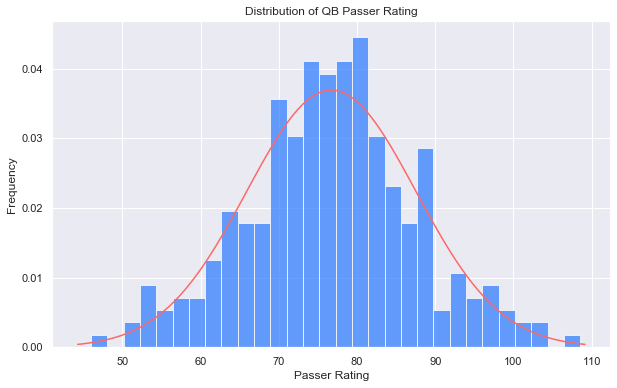

In [202]:
plot_hist_by_var(all_qb_stats, 'Rate')

We can also check the distribution of our samples, the case and control QBs. We can do this using a Q-Q plot, which plots two sets of quantiles together so we can visually check if the dependent variable fits a normal distribution. This is important to verify so that we can make claims of statistically significant changes when performances deviate. 

In [203]:
def probplot_by_var(qb_stats, var):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    stats.probplot(qb_stats[var], plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    plt.title('Probability Plot of {}'.format(stat_names[var]))
    plt.show()

Here are our case QBs passer ratings, prior to surgery, on a Q-Q plot. We can visually see that they fit the normal distribution well. 

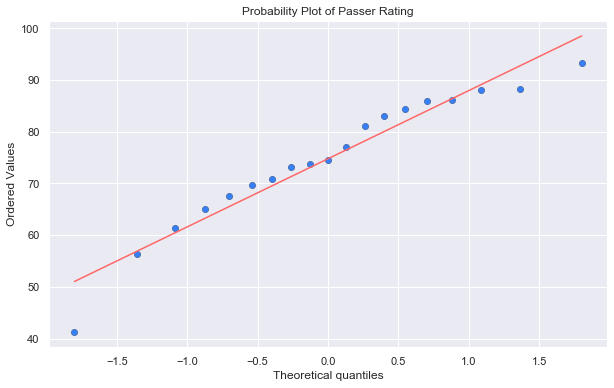

In [204]:
probplot_by_var(case_prev, 'Rate')

And all of our QBs:

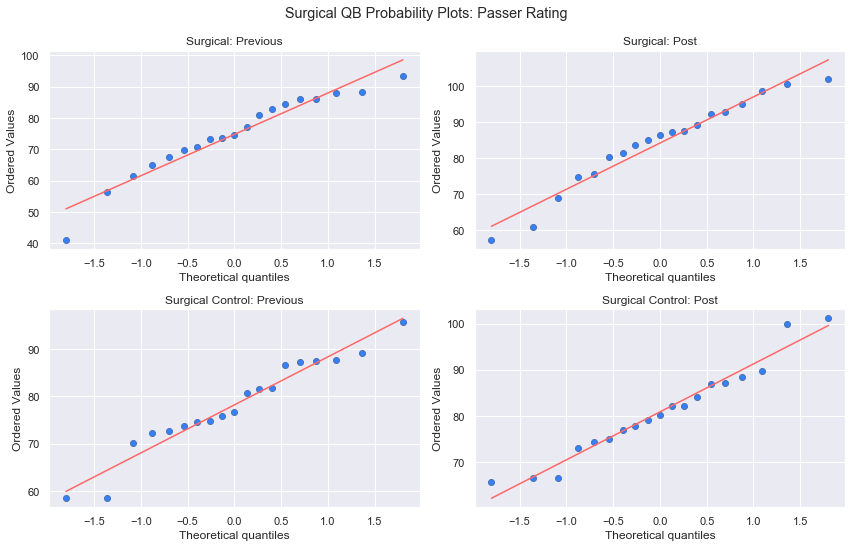

In [205]:
cohorts = [case_prev, case_post, ctrl_prev, ctrl_post]
cohort_names = ['Surgical: Previous', 'Surgical: Post', 'Surgical Control: Previous', 'Surgical Control: Post']
fig = plt.figure(figsize=(12,8))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    stats.probplot(cohorts[i]['Rate'], plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    ax.set_title(cohort_names[i])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Surgical QB Probability Plots: Passer Rating')
plt.show()

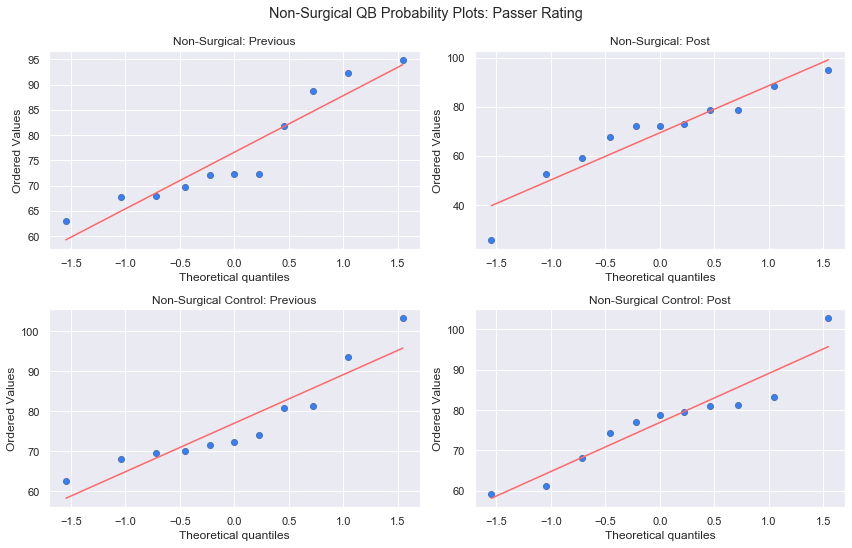

In [206]:
cohorts = [inj_prev, inj_post, inj_ctrl_prev, inj_ctrl_post]
cohort_names = ['Non-Surgical: Previous', 'Non-Surgical: Post', 'Non-Surgical Control: Previous', 'Non-Surgical Control: Post']
fig = plt.figure(figsize=(12,8))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    stats.probplot(cohorts[i]['Rate'], plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    ax.set_title(cohort_names[i])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Non-Surgical QB Probability Plots: Passer Rating')
plt.show()

## Shapiro-Wilk Test for Normality

In [207]:
stat, p = shapiro(all_qb_stats['Rate'])
print('Stat: '+str(stat)+'   p-value: '+str(p))

Stat: 0.9963261485099792   p-value: 0.7873727679252625


In [208]:
stat, p = shapiro(inj_prev['AY/A'])
print('Stat: '+str(stat)+'   p-value: '+str(p))

Stat: 0.9435199499130249   p-value: 0.562719464302063


## QB Performance Statistics

Now lets take a closer look at the performance statistics of QBs. We are looking at passing statistics that are consistently recorded for all of our QBs going back to 1980, these are: Passer Rating (Rate), Completion Percentage (Cmp%), Passing Yards (Yds), Completions (Cmp), Attempts (Att), Yards per Pass Attempt (Y/A), Adjusted Yards per Pass Attempt (AY/A), Passing Touchdowns (TD), Interceptions (Int), Sacks (Sk), and Yards Lost to Sacks (Yds.1). 

<br>

Passer Rating and Adjusted Yards per Attempt are calculations of several aggregated statistics. 

Passer Rating is calculated as follows:

(a + b + c + d) / 6 * 100

where

a = (CMP/ATT - 0.3) * 5

b = (YDS/ATT - 3) * 0.25

c = (TD/ATT) * 20

d = 2.375 - (INT/ATT * 25)

<br>

Adjusted Yards per Pass Attempt is calculated as follows:

AY/A = (YDS + 20 * TD - 45 * INT) / ATT

We can find an easier way to look at a QB's statistics than numbers on a chart, with a radial plot. Since statistics have very different ranges though, such as passing yards in the hundreds and interceptions per game less than 5, we have to look at these as percentages. Let's calculate a QB's statistics as a percentage of the population average. 

In [209]:
def get_player_percent(player, df, all_qbs):
    res = df[df['Name']==player]
    res.set_index('Name', drop=True, inplace=True)
    res.drop(columns=['Age', 'Games'], inplace=True)
    res = res[['Rate', 'Cmp%', 'Yds', 'Cmp', 'Att', 'Y/A', 'AY/A', 'TD', 'Int', 'Sk', 'Yds.1']]
    for var in res.columns:
        avgvar = all_qbs[var].mean()
        res[var] = res[var]/avgvar
    return res

In [210]:
smith_prev = get_player_percent('Alex Smith', case_prev, all_qb_stats)
smith_post = get_player_percent('Alex Smith', case_post, all_qb_stats)
smith_prev

,Rate,Cmp%,Yds,Cmp,Att,Y/A,AY/A,TD,Int,Sk,Yds.1
Name,,,,,,,,,,,
Alex Smith,0.848928,0.970117,0.848582,0.922007,0.980547,0.882464,0.787074,0.603743,1.128319,1.263911,1.160729


Lets plot Alex Smith's statistics before and after his surgery, as a percentage of the average NFL QB statistics.

In [211]:
def radar_plot(df1, df2, df3=None, df4=None, prevpost=False, max_val=1.5):    
    label1 = df1.index[0]+' (Previous)' if prevpost else df1.index[0]
    label2 = df2.index[0]+' (Post)' if prevpost else df2.index[0]
    if df3 is not None and df4 is not None:
        plt.figure(figsize=(18,18))
        ax = plt.subplot(121, polar=True)
    else: 
        plt.figure(figsize=(14,8))
        ax = plt.subplot(111, polar=True)
        plt.title('{} vs {}: % of NFL Average'.format(label1, label2))

    categories=list(df1)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.set_rlabel_position(0)
    yticks = [max_val*i/6*100 for i in range(1,6)]
    plt.yticks(yticks, [str(int(e))+'%' for e in yticks], color='grey', size=14)
    plt.ylim(0,max_val*100)
    colors = ['blue','red']
    
    values1 = df1.values.flatten().tolist()
    values1 += values1[:1]
    values1 = [x*100 for x in values1]
    ax.plot(angles, values1, linewidth=1, linestyle='solid', color=colors[0], label=label1)
    ax.fill(angles, values1, color=colors[0], alpha=0.1)
    values2 = df2.values.flatten().tolist()
    values2 += values2[:1]
    values2 = [x*100 for x in values2]
    ax.plot(angles, values2, linewidth=1, linestyle='solid', color=colors[1], label=label2)
    ax.fill(angles, values2, color=colors[1], alpha=0.1)
    plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
    
    if df3 is not None and df4 is not None:
        plt.title('{} vs {}: Previous, % of NFL Average'.format(label1, label2))
        ax = plt.subplot(122, polar=True)
        plt.xticks(angles[:-1], categories, color='black', size=12)
        ax.set_rlabel_position(0)
        yticks = [max_val*i/6*100 for i in range(1,6)]
        plt.yticks(yticks, [str(int(e))+'%' for e in yticks], color='grey', size=14)
        plt.ylim(0,max_val*100)
        values3 = df3.values.flatten().tolist()
        values3 += values3[:1]
        values3 = [x*100 for x in values3]
        ax.plot(angles, values3, linewidth=1, linestyle='solid', color=colors[0], label=df3.index[0])
        ax.fill(angles, values3, color=colors[0], alpha=0.1)
        values4 = df4.values.flatten().tolist()
        values4 += values4[:1]
        values4 = [x*100 for x in values4]
        ax.plot(angles, values4, linewidth=1, linestyle='solid', color=colors[1], label=df4.index[0])
        ax.fill(angles, values4, color=colors[1], alpha=0.1)
        plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
        plt.title('{} vs {}: Post, % of NFL Average'.format(df3.index[0], df4.index[0]))
    plt.show()

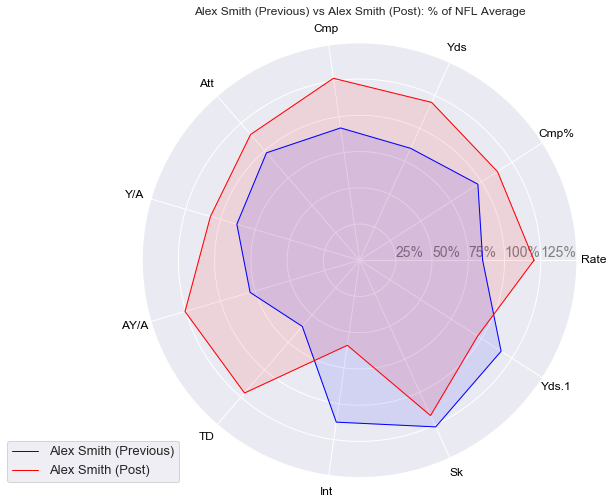

In [212]:
radar_plot(smith_prev, smith_post, prevpost=True)

Or we can compare two different QBs:

In [213]:
vick_prev = get_player_percent('Michael Vick', ctrl_prev, all_qb_stats)

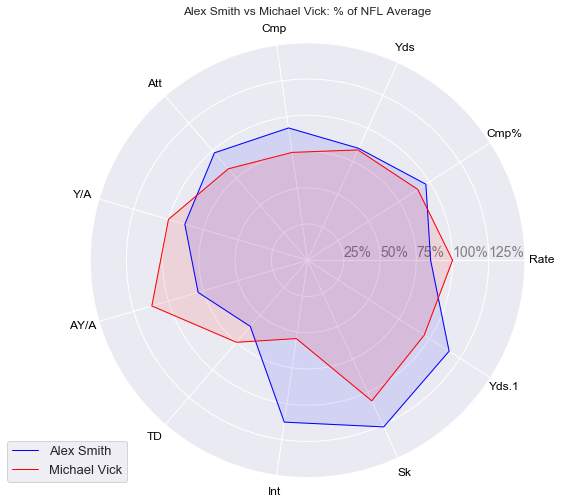

In [214]:
radar_plot(smith_prev, vick_prev)

And now lets look at Alex Smith and his control, Michael Vick, for their previous and post surgery/index performances.

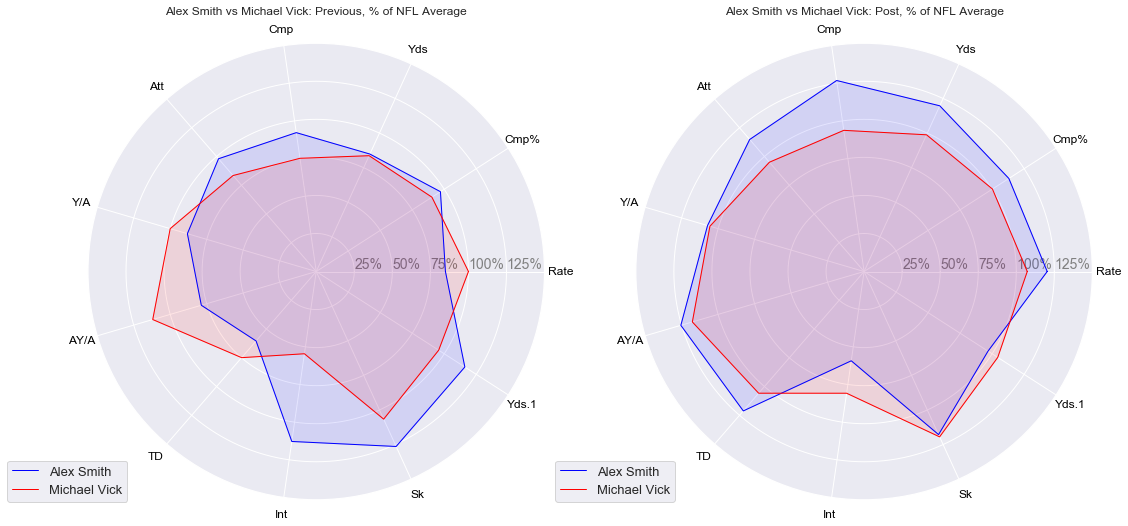

In [215]:
vick_post = get_player_percent('Michael Vick', ctrl_post, all_qb_stats)
radar_plot(smith_prev, vick_prev, smith_post, vick_post)

## Case QBs Pre and Post Surgery

The next step is to examine the performance statistics of our case QBs before and after their surgeries. We can look at the cohort as a whole. 

In [216]:
def plot_pre_post(case_prev, case_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
    for i in range(len(case_prev)):
        ax1.scatter(i/36, case_prev.iloc[i,var], color=blue, alpha=0.75)
        ax1.scatter(1+i/36, case_post.iloc[i,var], color=red, alpha=0.75)
    ax1.plot([0,0.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax1.plot([1,1.5], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linewidth=3)
    
    ax1.set_xlim(-0.5,2)
    ax1.set_xticks([.25,1.25])
    ax1.set_xticklabels(['Previous', 'Post'])
    ax1.set_ylabel(stat_names[var_name])

    for i in range(len(case_prev)):
        ax2.scatter(1, case_prev.iloc[i,var], color=blue, alpha=0.75)
        ax2.scatter(2, case_post.iloc[i,var], color=red, alpha=0.75)
        if case_post.iloc[i,var] - case_prev.iloc[i,var] > 0:
            c = 'green'
        else:
            c = 'red'
        ax2.plot([1, 2], [case_prev.iloc[i,var], case_post.iloc[i,var]], color=c, linewidth=0.5, alpha=0.5)
    ax2.set_xlim(0.5,2.5)
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(['Previous', 'Post'])

    return ax1, ax2

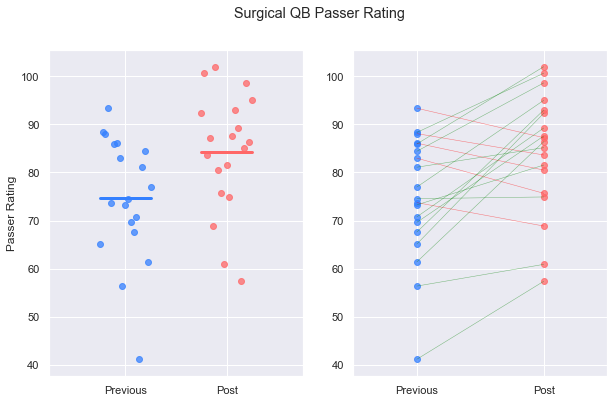

In [217]:
plot_pre_post(case_prev, case_post, 'Rate')
plt.suptitle('Surgical QB Passer Rating')
plt.show()

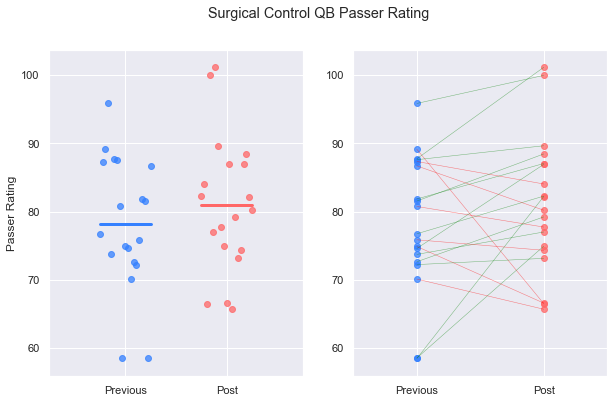

In [218]:
plot_pre_post(ctrl_prev, ctrl_post, 'Rate')
plt.suptitle('Surgical Control QB Passer Rating')
plt.show()

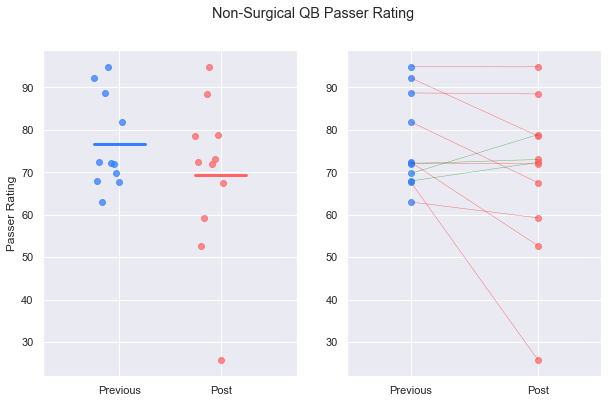

In [219]:
plot_pre_post(inj_prev, inj_post, 'Rate')
plt.suptitle('Non-Surgical QB Passer Rating')
plt.show()

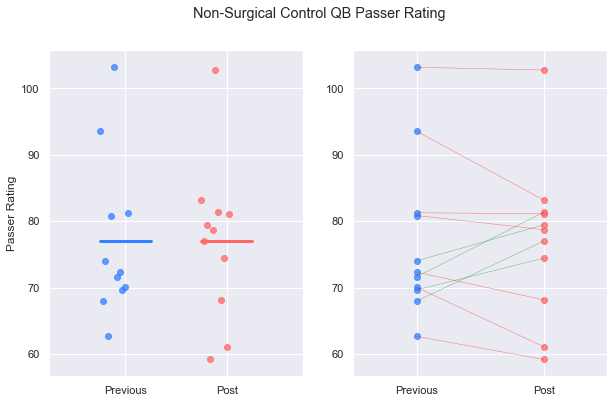

In [220]:
plot_pre_post(inj_ctrl_prev, inj_ctrl_post, 'Rate')
plt.suptitle('Non-Surgical Control QB Passer Rating')
plt.show()

In [221]:
def plot_case_control(case_prev, case_post, ctrl_prev, ctrl_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    length = len(case_prev)
    fig, ax = plt.subplots(figsize=(10,6))
    if len(case_prev)!=len(ctrl_prev):
        for i in range(len(case_prev)):
            ax.scatter(1.5+i/length, case_prev.iloc[i,var], color=red, alpha=0.75)
            ax.scatter(6+i/length, case_post.iloc[i,var], color=red, marker='^', alpha=0.75)
        for j in range(len(ctrl_prev)):
            ax.scatter(3+j/length, ctrl_prev.iloc[j,var], color=blue, alpha=0.75)
            ax.scatter(7.5+j/length, ctrl_post.iloc[j,var], color=blue, marker='^', alpha=0.75)
    else:
        for i in range(len(case_prev)):
            ax.scatter(1.5+i/length, case_prev.iloc[i,var], color=red, alpha=0.75)
            ax.scatter(3+i/length, ctrl_prev.iloc[i,var], color=blue, alpha=0.75)
            ax.scatter(6+i/length, case_post.iloc[i,var], color=red, marker='^', alpha=0.75)
            ax.scatter(7.5+i/length, ctrl_post.iloc[i,var], color=blue, marker='^', alpha=0.75)
    ax.plot([1.5,2.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=red, linewidth=3)
    ax.plot([3,4], [ctrl_prev.iloc[:,var].mean(), ctrl_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax.plot([6,7], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linestyle=':',linewidth=3)
    ax.plot([7.5,8.5], [ctrl_post.iloc[:,var].mean(), ctrl_post.iloc[:,var].mean()], color=blue, linestyle=':',linewidth=3)
    ax.set_xlim(0,10)
    ax.set_xticks([2.75, 7.25])
    ax.set_xticklabels(['Previous', 'Post'])
    ax.set_ylabel('{}'.format(stat_names[var_name]))
    return ax

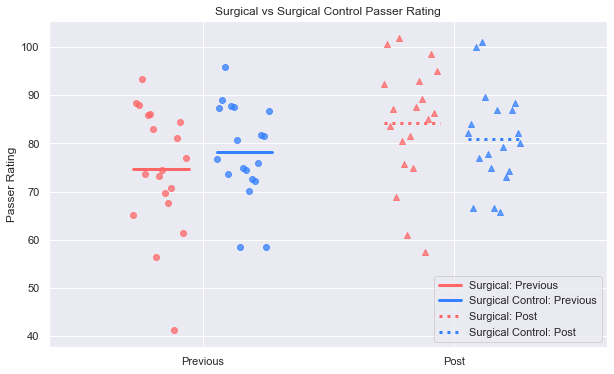

In [222]:
plot_case_control(case_prev, case_post, ctrl_prev, ctrl_post, 'Rate')
plt.title('Surgical vs Surgical Control Passer Rating')
plt.legend(['Surgical: Previous', 'Surgical Control: Previous', 'Surgical: Post', 'Surgical Control: Post'])
plt.show()

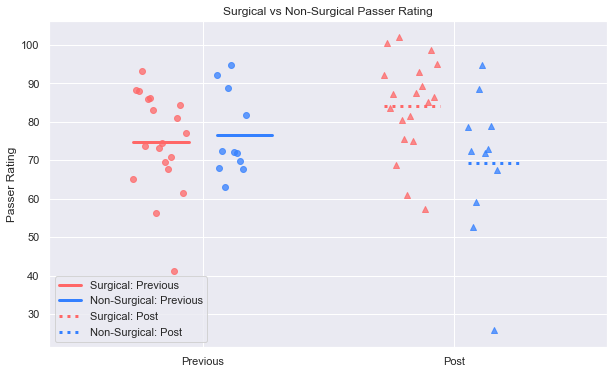

In [223]:
plot_case_control(case_prev, case_post, inj_prev, inj_post, 'Rate')
plt.title('Surgical vs Non-Surgical Passer Rating')
plt.legend(['Surgical: Previous', 'Non-Surgical: Previous', 'Surgical: Post', 'Non-Surgical: Post'])
plt.show()

do one cohort on left, pre and post, one cohort on the right, pre and post

In [224]:
def plot_pre_post_two_cohorts(case_prev, case_post, ctrl_prev, ctrl_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
    for i in range(len(case_prev)):
        ax1.scatter(i/36, case_prev.iloc[i,var], color=blue, alpha=0.75)
        ax1.scatter(1+i/36, case_post.iloc[i,var], color=red, alpha=0.75)
    ax1.plot([0,0.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax1.plot([1,1.5], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linewidth=3)
    
    ax1.set_xlim(-0.5,2)
    ax1.set_ylim(20,110)
    ax1.set_xticks([.25,1.25])
    ax1.set_xticklabels(['Previous', 'Post'])
    ax1.set_ylabel(stat_names[var_name])

    for i in range(len(ctrl_prev)):
        ax2.scatter(i/36, ctrl_prev.iloc[i,var], color=blue, alpha=0.75)
        ax2.scatter(1+i/36, ctrl_post.iloc[i,var], color=red, alpha=0.75)
    ax2.plot([0,0.5], [ctrl_prev.iloc[:,var].mean(), ctrl_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax2.plot([1,1.5], [ctrl_post.iloc[:,var].mean(), ctrl_post.iloc[:,var].mean()], color=red, linewidth=3)
    
    ax2.set_xlim(-0.5,2)
    ax2.set_ylim(20,110)
    ax2.set_xticks([.25,1.25])
    ax2.set_xticklabels(['Previous', 'Post'])

    return ax1, ax2

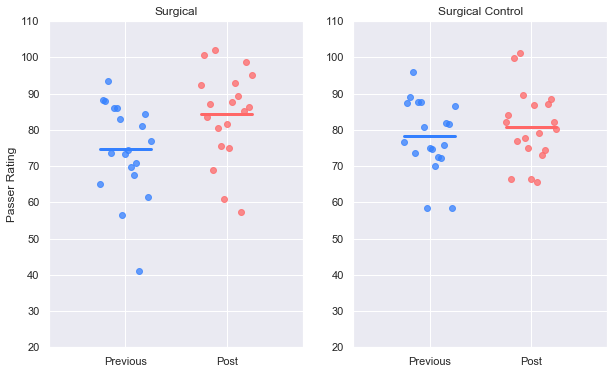

In [225]:
ax1, ax2 = plot_pre_post_two_cohorts(case_prev, case_post, ctrl_prev, ctrl_post, 'Rate')
ax1.set_title('Surgical')
ax2.set_title('Surgical Control')
plt.show()

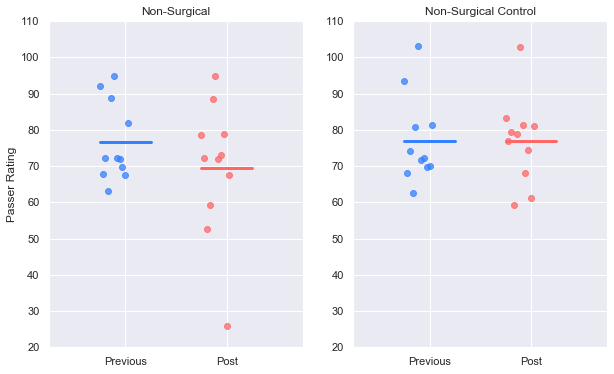

In [226]:
ax1, ax2 = plot_pre_post_two_cohorts(inj_prev, inj_post, inj_ctrl_prev, inj_ctrl_post, 'Rate')
ax1.set_title('Non-Surgical')
ax2.set_title('Non-Surgical Control')
plt.show()

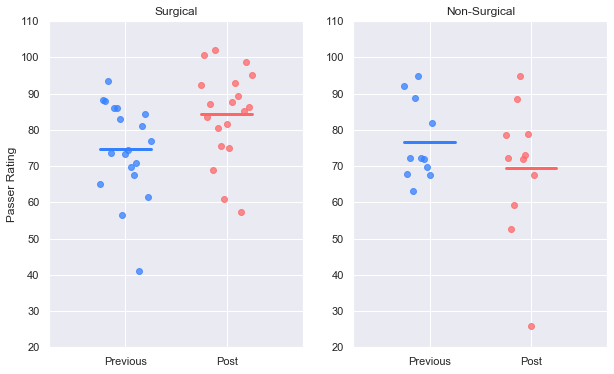

In [227]:
ax1, ax2 = plot_pre_post_two_cohorts(case_prev, case_post, inj_prev, inj_post, 'Rate')
ax1.set_title('Surgical')
ax2.set_title('Non-Surgical')
plt.show()

In [58]:
def ttest_ind_gsa(case_prev, case_post, ctrl_prev, ctrl_post, var):
    n = len(case_prev)
    case_diff = case_post[var]-case_prev[var]
    ctrl_diff = ctrl_post[var]-ctrl_prev[var]
    diff = case_diff.mean()-ctrl_diff.mean()
    sign = '+' if diff>0 else ''
    ttest = stats.ttest_ind(case_diff, ctrl_diff);
    print(var+' %1.6f'%ttest[1])
#     print('Case: %1.4f'%case_diff.mean()+'    Control: %1.4f'%ctrl_diff.mean()+'    Gain Score: '+sign+'%1.4f'%diff)
#     print('   n: %1d'%n+'        t-value: %1.4f'%ttest[0]+'       p-value: %1.6f'%ttest[1])
#     return(case_diff.mean()-ctrl_diff.mean(), ttest[1])
#     return

def ttest_rel_by_var(prev, post, var):
    n = len(prev)
    prev_mean = prev[var].mean()
    post_mean = post[var].mean()
    diff = post_mean-prev_mean
    sign='+' if diff>0 else ''
    ttest = stats.ttest_rel(prev[var], post[var])
#     print(var+' %1.6f'%ttest[1])
#     print('Previous: %1.4f'%prev_mean+'    Post: %1.4f'%post_mean+'    Difference: '+sign+'%1.4f'%diff)
#     print('       n: %1d'%n+'      t-value: %1.4f'%ttest[0]+'       p-value: %1.4f'%ttest[1])
    return diff, ttest[1]

def ttest_ind_by_var(case, ctrl, var):
    n = len(case)
    case_mean = case[var].mean()
    ctrl_mean = ctrl[var].mean()
    diff = case_mean-ctrl_mean
    sign = '+' if diff>0 else ''
    ttest = stats.ttest_ind(case[var], ctrl[var])
#     print(var+' %1.6f'%ttest[1])
#     print('Case: %1.4f'%case_mean+'    Control: %1.4f'%ctrl_mean+'    Difference: '+sign+'%1.4f'%diff)
#     print('   n: %1d'%n+'         t-value: %1.4f'%ttest[0]+'       p-value: %1.4f'%ttest[1])
    return diff, ttest[1]

def pooled_standard_deviation(sample1,sample2):
    n1, n2 = len(sample1), len(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    return ((u1 - u2) / s_pooled)

def calc_power(case_prev, case_post, ctrl_prev, ctrl_post, var='Rate', alpha=0.05, ratio=1):
    case_diff = case_post[var]-case_prev[var]
    ctrl_diff = ctrl_post[var]-ctrl_prev[var]
    effect_size = Cohens_d(case_diff, ctrl_diff)
    analysis = TTestIndPower()
    power = analysis.solve_power(effect_size, power=None, nobs1=len(case_diff), ratio=ratio, alpha=alpha)
    return power

In [59]:
inj_ctrl_prev['Y/A'].mean()

6.925943760739146

In [60]:
inj_ctrl_post['Y/A'].mean()
stats.ttest_rel(inj_ctrl_prev['Y/A'], inj_ctrl_post['Y/A'])

Ttest_relResult(statistic=2.285808625454787, pvalue=0.04533572150522729)

In [61]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(inj_ctrl_prev, inj_ctrl_post, var)
    print('%0.6f'%t)

0.976863
0.525859
0.401241
0.366624
0.535961
0.811952
0.124353
0.898152
0.983476
0.045336
0.418608


In [62]:
length = len(case_prev)
effect_size = Cohens_d(case_prev, ctrl_prev)
analysis = TTestIndPower()
# power = analysis.solve_power(effect_size, power=None, nobs1=len(case_post), ratio=19/11, alpha=0.05)
power = analysis.solve_power(effect_size, power=None, nobs1=length, alpha=0.05)
power

Games    0.050991
Age      0.056371
Cmp      0.069546
Att      0.069461
Cmp%     0.060044
Yds      0.124910
TD       0.134791
Int      0.069975
Rate     0.145709
Sk       0.060053
Yds.1    0.068032
Y/A      0.131220
AY/A     0.213238
dtype: float64

In [63]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    ttest_ind_gsa(case_prev, case_post, ctrl_prev, ctrl_post, var)

Rate 0.064168
Cmp 0.079766
Att 0.196177
Cmp% 0.030733
Yds 0.168453
TD 0.098384
Int 0.344487
Sk 0.975461
Yds.1 0.706059
Y/A 0.400659
AY/A 0.090182


In [64]:
case_diff = case_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-case_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
ctrl_diff = ctrl_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-ctrl_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
case_diff.head()

,Rate,Cmp,Att,Cmp%,Yds,TD,Int,Sk,Yds.1,Y/A,AY/A
0,27.184286,5.442857,4.542857,9.174190,64.054762,0.638095,-0.490476,-0.180952,-2.757143,1.271571,2.719762
1,12.310357,4.446429,2.066071,8.126321,14.519643,0.551786,-0.033929,-1.103571,-5.767857,0.073179,0.474232
2,-4.441515,0.786816,-1.266480,4.434229,-23.585788,-0.353670,0.030856,-0.245909,-3.725105,-0.708595,-1.220972
3,-6.116870,1.529472,2.140244,1.914797,5.408537,-0.271850,0.112297,0.345020,1.562500,-0.624624,-0.927043
4,-4.865152,-4.926768,-8.780303,2.503165,-80.955387,-0.603535,-0.267677,-0.505051,-2.590067,-0.812029,-0.684613


In [65]:
inj_diff = inj_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-inj_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
inj_ctrl_diff = inj_ctrl_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-inj_ctrl_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
inj_diff.head()

,Rate,Cmp,Att,Cmp%,Yds,TD,Int,Sk,Yds.1,Y/A,AY/A
0,-13.653712,-4.045617,-3.490608,-5.046869,-67.963327,-0.670394,-0.378354,-0.020572,-1.375224,-1.430586,-1.525116
1,4.384483,-2.000000,-2.474138,-1.094310,-24.629310,-0.301724,-1.051724,-0.741379,-7.931034,-0.215603,1.192586
2,-19.631973,-2.537415,-3.845805,-6.182313,-39.918367,-0.585034,0.213152,0.140590,1.641723,-0.944807,-3.392154
3,-3.733333,-8.080460,-13.712644,-6.852989,-75.275862,-0.356322,-0.459770,-1.459770,-8.908046,0.068966,-0.177011
4,-0.234762,1.633333,1.903175,1.425817,32.993651,0.323810,0.593651,0.603175,1.938095,0.499929,-0.093190


In [66]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_ind_by_var(inj_diff, inj_ctrl_diff, var)
    print('%0.6f'%t)

0.151881
0.249897
0.219404
0.496504
0.140228
0.512848
0.580602
0.673149
0.372212
0.541288
0.162915


In [67]:
length = len(case_diff)
effect_size = Cohens_d(case_diff, inj_diff)
analysis = TTestIndPower()
power = analysis.solve_power(effect_size, power=None, nobs1=len(case_diff), ratio=11/19, alpha=0.05)
# power = analysis.solve_power(effect_size, power=None, nobs1=length, alpha=0.05)
power

Rate     0.916106
Cmp      0.811688
Att      0.473051
Cmp%     0.951313
Yds      0.730231
TD       0.576178
Int      0.135524
Sk       0.059391
Yds.1    0.074562
Y/A      0.674164
AY/A     0.643727
dtype: float64

In [68]:
inj_diff.mean()

Rate     -7.193791
Cmp      -1.428834
Att      -2.022242
Cmp%     -3.349662
Yds     -23.132211
TD       -0.147773
Int      -0.072655
Sk       -0.240826
Yds.1    -2.620376
Y/A      -0.622085
AY/A     -0.706054
dtype: float64

# Injury Stratified Statistics

*Copying code from above for ease of re-calculating

In [69]:
def stratify(cases_list, names_list):
    df = pd.DataFrame()
    for name in names_list:
        df = df.append(cases_list[cases_list['Name']==name])
    df.reset_index(drop=True, inplace=True)
    return df
labrum_case_qbs = stratify(case_qbs, ['Rich Gannon', 'Drew Brees', 'Matt Moore', 'Jimmy Clausen', 'Mark Sanchez', 'Jay Cutler', 'Ryan Leaf', 'Andrew Luck', 'Kelly Holcomb'])
labrum_case_qbs

,Name,Year,Age,Surgery,Experience,Birthday,SurgeryAge,Control
0,Rich Gannon,1987,22,11/13/1993,6,10/20/1965,28.084932,Tommy Kramer
1,Drew Brees,2001,22,12/31/2005,5,1/15/1979,26.978082,Peyton Manning
2,Matt Moore,2007,23,11/7/2010,3,8/9/1984,26.263014,Geno Smith
3,Jimmy Clausen,2010,23,8/29/2013,3,9/21/1987,25.956164,Kellen Clemens
4,Mark Sanchez,2009,23,8/24/2013,4,11/11/1986,26.802740,Kyle Orton
5,Jay Cutler,2006,23,11/20/2016,10,4/29/1983,33.586301,Matt Schaub
6,Ryan Leaf,1998,22,6/1/1999,1,5/15/1976,23.060274,Tim Couch
7,Andrew Luck,2012,23,1/19/2017,5,9/12/1989,27.372603,Joe Flacco
8,Kelly Holcomb,1997,24,2/10/2004,7,7/9/1973,30.610959,Donald Hollas


In [70]:
labrum_inj_qbs = stratify(inj_qbs, ['Kyle Boller'])
separated_case_qbs = stratify(case_qbs, ['Tom Brady', 'Troy Aikman'])
separated_inj_qbs = stratify(inj_qbs, ['Bruce Gradkowski', 'Jim Miller', 'Scott Mitchell', 'Gary Hogeboom', 'David Archer'])
separated_inj_qbs

,Name,Year,Age,Surgery,Experience,Birthday,SurgeryAge,Control
0,Bruce Gradkowski,2006,23,11/28/2010,4,1/27/1983,27.854795,Brady Quinn
1,Jim Miller,1995,24,1/19/2002,6,2/9/1971,30.964384,Hugh Millen
2,Scott Mitchell,1991,23,11/6/1993,2,1/2/1968,25.863014,Doug Johnson
3,Gary Hogeboom,1980,22,9/14/1986,6,8/21/1958,28.084932,Steve Grogan
4,David Archer,1984,22,11/16/1986,2,2/15/1962,24.767123,Todd Blackledge


In [71]:
labrum_case_prev, labrum_case_post, labrum_ctrl_prev, labrum_ctrl_post = get_case_control_prev_post(labrum_case_qbs, select_ctrls)
labrum_inj_prev, labrum_inj_post, labrum_inj_ctrl_prev, labrum_inj_ctrl_post = get_case_control_prev_post(labrum_inj_qbs, inj_ctrls)
separated_case_prev, separated_case_post, separated_ctrl_prev, separated_ctrl_post = get_case_control_prev_post(separated_case_qbs, select_ctrls)
separated_inj_prev, separated_inj_post, separated_inj_ctrl_prev, separated_inj_ctrl_post = get_case_control_prev_post(separated_inj_qbs, inj_ctrls)

In [72]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(labrum_case_prev, labrum_case_post, var)
    print(var+': %0.6f'%t)

Rate: 0.008636
Cmp: 0.017808
Att: 0.083937
Cmp%: 0.008175
Yds: 0.079202
TD: 0.007625
Int: 0.145097
Sk: 0.715347
Yds.1: 0.499779
Y/A: 0.230132
AY/A: 0.051120


In [73]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(labrum_ctrl_prev, labrum_ctrl_post, var)
    print(var+': %0.6f'%t)

Rate: 0.328547
Cmp: 0.748467
Att: 0.520097
Cmp%: 0.881491
Yds: 0.619059
TD: 0.852633
Int: 0.964282
Sk: 0.499298
Yds.1: 0.461626
Y/A: 0.731449
AY/A: 0.963483


In [74]:
labrum_inj_post

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Kyle Boller,9,28.699,12.666667,22.888889,51.236667,120.0,0.333333,1.111111,52.733333,2.222222,15.111111,5.161111,1.711111


In [75]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(labrum_inj_prev, labrum_inj_post, var)
    print(var+': %0.6f'%t)

Rate: nan
Cmp: nan
Att: nan
Cmp%: nan
Yds: nan
TD: nan
Int: nan
Sk: nan
Yds.1: nan
Y/A: nan
AY/A: nan


C:\Users\ggdur\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\ggdur\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ggdur\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\ggdur\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\ggdur\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [76]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(labrum_inj_ctrl_prev, labrum_inj_ctrl_post, var)
    print(var+': %0.6f'%t)

Rate: nan
Cmp: nan
Att: nan
Cmp%: nan
Yds: nan
TD: nan
Int: nan
Sk: nan
Yds.1: nan
Y/A: nan
AY/A: nan


In [87]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(separated_inj_ctrl_prev, separated_inj_ctrl_post, var)
    print('%0.6f'%t)

0.906759
0.374620
0.293430
0.429313
0.163862
0.167031
0.057223
0.635758
0.528447
0.089506
0.987816


In [107]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(ac_case_prev, ac_case_post, var)
    print('%0.6f'%t)

0.678497
0.231814
0.227853
0.436076
0.440551
0.784996
0.609774
0.748275
0.381758
0.841329
0.764890


In [108]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(ac_ctrl_prev, ac_ctrl_post, var)
    print('%0.6f'%t)

0.773944
0.945982
0.798791
0.298792
0.830534
0.259102
0.370363
0.487197
0.479920
0.930765
0.936104


In [109]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(ac_inj_prev, ac_inj_post, var)
    print('%0.6f'%t)

0.498810
0.929394
0.786064
0.619527
0.752419
0.848990
0.519039
0.490119
0.385393
0.187019
0.288799


In [110]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_rel_by_var(ac_inj_ctrl_prev, ac_inj_ctrl_post, var)
    print('%0.6f'%t)

0.474774
0.935956
0.773724
0.432482
0.694344
0.380860
0.426180
0.243303
0.841387
0.069493
0.344166


In [77]:
labrum_case_diff = labrum_case_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-labrum_case_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
labrum_ctrl_diff = labrum_ctrl_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-labrum_ctrl_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
labrum_inj_diff = labrum_inj_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-labrum_inj_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
labrum_inj_ctrl_diff = labrum_inj_ctrl_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-labrum_inj_ctrl_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
labrum_case_diff.head()

,Rate,Cmp,Att,Cmp%,Yds,TD,Int,Sk,Yds.1,Y/A,AY/A
0,18.463321,5.963384,7.611742,6.953150,69.062500,0.488005,-0.279672,0.112374,-0.104798,0.756540,2.072500
1,16.056410,7.341895,7.709027,6.566857,89.429926,0.793848,-0.061301,-0.123199,-2.328455,0.896180,1.445129
2,17.931969,3.497076,4.658869,4.794172,44.126706,0.380117,-0.138402,0.674464,3.497076,0.476335,1.545653
3,4.515385,1.780220,1.571429,0.068462,16.296703,0.340659,0.021978,-1.109890,-8.868132,0.227143,0.755385
4,0.357596,2.147541,-0.473224,5.954765,18.903825,0.085246,0.202186,0.734426,4.723497,0.361104,-0.299770


In [78]:
separated_case_diff = separated_case_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-separated_case_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
separated_ctrl_diff = separated_ctrl_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-separated_ctrl_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
separated_inj_diff = separated_inj_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-separated_inj_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]
separated_inj_ctrl_diff = separated_inj_ctrl_post[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]-separated_inj_ctrl_prev[['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]

In [79]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_ind_by_var(labrum_case_diff, labrum_ctrl_diff, var)
    print(var+': %0.6f'%t)

Rate: 0.117264
Cmp: 0.098821
Att: 0.181337
Cmp%: 0.146275
Yds: 0.152832
TD: 0.096687
Int: 0.706190
Sk: 0.733009
Yds.1: 0.825058
Y/A: 0.409080
AY/A: 0.128643


In [260]:
for var in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    d, t = ttest_ind_by_var(separated_case_diff, separated_inj_diff, var)
    print(var+': %0.6f'%t)

Rate: 0.139221
Cmp: 0.349411
Att: 0.518651
Cmp%: 0.315958
Yds: 0.203547
TD: 0.384670
Int: 0.123298
Sk: 0.560602
Yds.1: 0.605875
Y/A: 0.139714
AY/A: 0.238029
